# Demonstration of basic_datasets use
 - Written for ELE 396 quantum machine learning pojects
 - clone this repo, or just download the `basic_datasets.py` module to use
 - `demo_script.ipynb` is this README in notebook form
 - demonstrates use of functions in `basic_datasets` to generate datasets and corresponding labels
 - classification datasets for toy machine learning problems, emphasis on application to quantum machine learning
 - datasets generated in this notebook are $(N \times D)$: $D$ is the dimension of each datapoint and $N$ is the number of distinct points. 
 - These can just be transposed for the opposite convention, which is what the helper functions in `basic_datasets` naturally use
 - inputs are arrays that are `x_[name]`, the associated targets are `Y_[name]`


In [35]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
import pandas as pd

from basic_datasets import *

try:
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.svm import SVC
    from sklearn.neural_network import MLPClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from scipy import stats
    SKLEARN_AVAILABLE = True
    print("✓ All required packages loaded successfully")
except ImportError as e:
    SKLEARN_AVAILABLE = False
    print(f"⚠ Warning: sklearn not installed. Install with: pip install scikit-learn")
    print(f"⚠ Comparative study features will not work until sklearn is installed.")

ModuleNotFoundError: No module named 'pandas'

## N-spheres
- here choosing n=2, so we are just classifying points based on the radius of the circle they lie on
- generate points on each circle `x_circle[i]`, and then combine to form a single dataset
- `Y_circle1` are class labels for corresponding points in `x_circle`, as colored in the plot below
- example: https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.14.034034


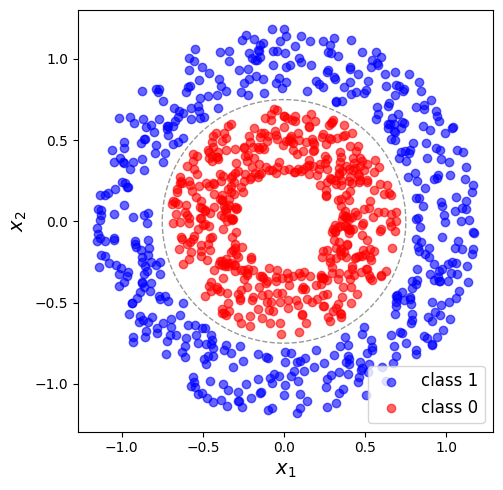

In [36]:
# circles dataset

#parameters of noisy nspheres
D_circle = 2 # number of dimensions
N_circle = 1000 # number of total datapoints
r1, r0 = 1, 0.5 # circle radii, r1>r0
dr = 0.2 # fluctuation in circle radii
r_mid =(r1+r0)/2 # dividing boundary

# generate input set from each class
x_circle1 =  r1*Noisy_nsphere_sample(dr/r1, int(N_circle/2), ndim=D_circle).T
x_circle0 =  r0*Noisy_nsphere_sample(dr/r0, int(N_circle/2), ndim=D_circle).T
# concatenate to 1 dataset, with alternating labels
x_circle = np.dstack((x_circle1.T, x_circle0.T)).reshape(D_circle,  N_circle).T 

# class labels, assign to class 1 if in circle1, assign to class 0 in circle 0
rad_circle = np.sqrt(np.sum(x_circle**2, axis=1)) # radius of each datapoint
Y_circle = np.array(rad_circle > r_mid).astype(float) # assign to appropriate radius

# # visualize boundary
theta_plot = np.linspace(0, 2*np.pi, 100)
circ_x1bound, circ_x2bound = r_mid*np.cos(theta_plot), r_mid*np.sin(theta_plot)

# plot dataset
fig_circle, ax_circle =  plt.subplots(1, 1, figsize=(6,5))
ax_circle.plot(circ_x1bound, circ_x2bound, '--k', linewidth=1, alpha = .4)
ax_circle.scatter(x_circle[np.argwhere(Y_circle), 0], x_circle[np.argwhere(Y_circle), 1],
                  color = f'b',marker = 'o', alpha = .6, label = 'class 1')
ax_circle.scatter(x_circle[np.argwhere(Y_circle<0.5), 0], x_circle[np.argwhere(Y_circle<0.5), 1],
                  color = f'r',marker = 'o', alpha = .6, label = 'class 0')
ax_circle.set_xlabel('$x_1$', fontsize=14), ax_circle.set_ylabel('$x_2$', fontsize=14)
ax_circle.legend(fontsize=12)
ax_circle.set_aspect('equal', 'box')
fig_circle.tight_layout()


# Spirals
- same concept as circles above, a 2d dataset divided into 2 classes
- now each class is a spiral arm starting at a specified angle, below angeles are $c=0$ and $\pi$
- this is then harder to separate than the circles, which just require a radius calculation
- example: https://doi.org/10.1080/09540090701398017
- example: https://playground.tensorflow.org/

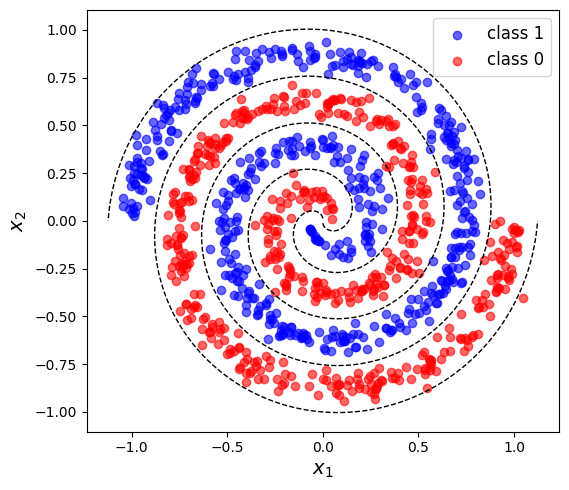

In [37]:
# Spirals dataset

#parameters of spirals
D_spiral = 2
N_spiral = 1000
cphase = [0, 1] # starting angles, units of pi
Nturns = 4 # number of pi/2 rotations per spiral arm
Sep = 0.05 # separation of arms at origin (small, poistive)
W = 0.5 # relative width of spiral arms due to noise

# generate input set from each class
x_spiral0 = Spiral_sample2(W, int(N_spiral/2), ts = cphase[0]*np.pi, Nturns = Nturns, Sep = Sep).T
x_spiral1 = Spiral_sample2(W, int(N_spiral/2), ts = cphase[1]*np.pi, Nturns = Nturns, Sep = Sep).T
# concatenate to 1 dataset, with alternating labels
x_spiral = np.dstack((x_spiral1.T, x_spiral0.T)).reshape(D_spiral,  N_spiral).T 

# class labels, assign to class 1 if in spiral 1, assign to class 0 if in spiral 0
Y_spiral = np.dstack((np.ones(int(N_spiral/2)),np.zeros(int(N_spiral/2)) )).flatten() # class 1 maps to 1, class 0 to 0


# useful functions for visualization
# define center line of each spiral
spiral_center0 = Spiral_line(int(N_spiral/2), ts = cphase[0]*np.pi, Nturns = Nturns, Sep = Sep)
spiral_center1 = Spiral_line(int(N_spiral/2), ts = cphase[1]*np.pi, Nturns = Nturns, Sep = Sep)
# normalise centers
Spiral_length = np.max([np.max(np.abs(spiral_center0)), np.max(np.abs(spiral_center0))])
spiral_center0, spiral_center1 = spiral_center0/Spiral_length, spiral_center1/ Spiral_length
# separating lines
spiral_mid1 = Spiral_line(int(N_spiral/2), ts = np.mean(cphase)*np.pi, Nturns = Nturns+.5, Sep = Sep)/ Spiral_length
spiral_mid2 = Spiral_line(int(N_spiral/2), ts = (np.mean(cphase)-1)*np.pi, Nturns = Nturns+.5, Sep = Sep)/ Spiral_length

fig_spiral, ax_spiral =  plt.subplots(1, 1, figsize=(6,5))

ax_spiral.scatter(x_spiral[np.argwhere(Y_spiral), 0], x_spiral[np.argwhere(Y_spiral), 1],
                  color = f'b',marker = 'o', alpha = .6, label = 'class 1')
ax_spiral.scatter(x_spiral[np.argwhere(Y_spiral<0.5), 0], x_spiral[np.argwhere(Y_spiral<0.5), 1],
                  color = f'r',marker = 'o', alpha = .6, label = 'class 0')
ax_spiral.plot(spiral_mid1[0], spiral_mid1[1], '--k', linewidth=1)
ax_spiral.plot(spiral_mid2[0], spiral_mid2[1], '--k', linewidth=1)
ax_spiral.set_xlabel('$x_1$', fontsize=14), ax_spiral.set_ylabel('$x_2$', fontsize=14)
ax_spiral.legend(fontsize=12)
ax_spiral.set_aspect('equal', 'box')
fig_spiral.tight_layout()


## Bars and Stripes
- this is another popular dataset for quantum machine learning because it is small and binary valued
- dataset consists of 16 4-bit binary strings (
- they are classified as to whether they contain a bar/stripe (exactly one row/column of 1s) or not
- some different definitions exist in liturature, can just change target labelling appropriately
- example: https://www.nature.com/articles/s41534-019-0157-8
- example: https://iopscience.iop.org/article/10.1088/2058-9565/abb8e4


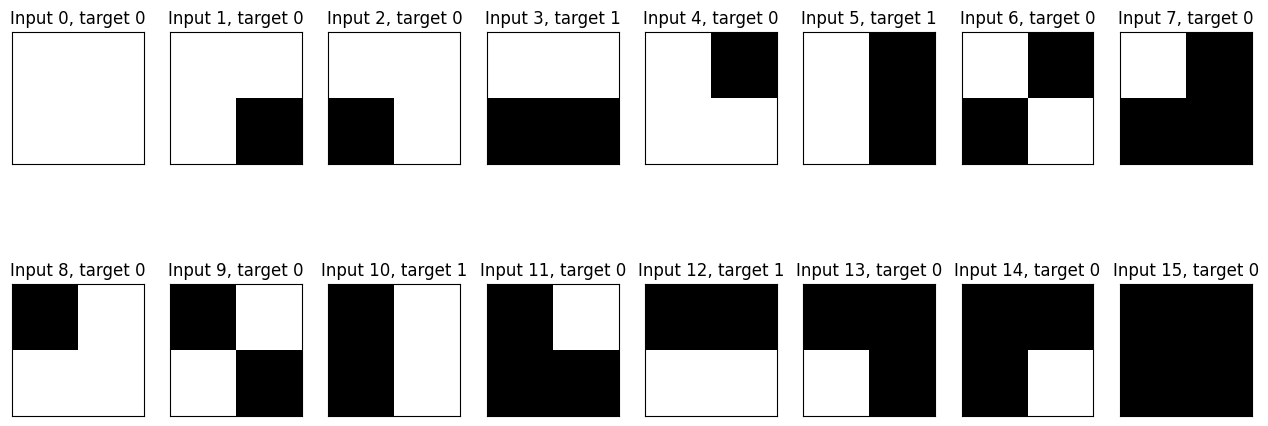

In [38]:
#BAS dataset
# input
BAS_data = [[0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 1],
            [0, 1, 0, 0], [0, 1, 0, 1], [0, 1, 1, 0], [0, 1, 1, 1],
            [1, 0, 0, 0], [1, 0, 0, 1], [1, 0, 1, 0], [1, 0, 1, 1],
            [1, 1, 0, 0], [1, 1, 0, 1], [1, 1, 1, 0], [1, 1, 1, 1]]
x_BAS = np.array(BAS_data) #dataset
(N_BAS, D_BAS) = x_BAS.shape

# labelling strings
xstr_BAS = [str(key) for key in x_BAS] 
xstr_BAS_binary = [ind for ind in range(len(xstr_BAS))]

# array of target outputs - class labels
Y_BAS = np.array([0, 0, 0, 1,
                0, 1, 0, 0,
                0, 0, 1, 0,
                1, 0, 0, 0])


#generate quick image of BAS data
BAS_images = []
for q in range(N_BAS):
    BAS_images.append(np.array(BAS_data[q]).reshape(2,2))
cutfact = 2
fig_BAS, ax_BAS = plt.subplots(cutfact,int(N_BAS/cutfact), figsize=(16,6))
ax_BAS = ax_BAS.flatten()
for q in range(N_BAS):
    ax_BAS[q].matshow(BAS_images[q], cmap = 'binary', alpha = 1, clim = [0,1])
    ax_BAS[q].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])
    ax_BAS[q].set_title(f"Input {q}, target {Y_BAS[q]}")

# Comparative Study: Classical vs Quantum ML Algorithms

We'll use the **spirals dataset** for our comparative study because:
- Easy to visualize (2D)
- Adjustable difficulty via `Nturns` parameter
- Non-linearly separable (tests algorithm capabilities)
- Standard benchmark in QML literature

We'll test multiple difficulty levels and compare:
- **Classical algorithms**: SVM with RBF kernel, Neural Networks, etc.
- **Quantum algorithms**: Variational Quantum Classifier (VQC), Quantum Kernel methods, etc.

In [39]:
# Check if sklearn is available before running comparative study code
if not SKLEARN_AVAILABLE:
    print("=" * 70)
    print("SKLEARN NOT INSTALLED")
    print("=" * 70)
    print("\nTo use the comparative study features, please install scikit-learn:")
    print("\n  pip install scikit-learn scipy")
    print("\nAfter installation, restart the kernel and run the cells again.")
    print("=" * 70)
else:
    # Generate spirals datasets with varying difficulty levels
    def generate_spiral_dataset(N_points=1000, Nturns=4, W=0.5, test_size=0.3, random_state=42):
        """
        Generate a spirals dataset with train/test split
        
        Parameters:
        -----------
        N_points : int
            Total number of datapoints
        Nturns : int
            Number of turns (difficulty parameter - higher is harder)
        W : float
            Width of spiral arms (noise strength)
        test_size : float
            Proportion of data to use for testing
        random_state : int
            Random seed for reproducibility
        
        Returns:
        --------
        X_train, X_test, Y_train, Y_test : arrays
            Training and testing splits
        """
        D_spiral = 2
        cphase = [0, 1]  # starting angles, units of pi
        Sep = 0.05  # separation of arms at origin
        
        # Generate spiral arms
        x_spiral0 = Spiral_sample2(W, int(N_points/2), ts=cphase[0]*np.pi, Nturns=Nturns, Sep=Sep).T
        x_spiral1 = Spiral_sample2(W, int(N_points/2), ts=cphase[1]*np.pi, Nturns=Nturns, Sep=Sep).T
        
        # Concatenate to single dataset
        X = np.dstack((x_spiral1.T, x_spiral0.T)).reshape(D_spiral, N_points).T
        
        # Class labels
        Y = np.dstack((np.ones(int(N_points/2)), np.zeros(int(N_points/2)))).flatten()
        
        # Split into train/test
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, 
                                                              random_state=random_state, stratify=Y)
        
        return X_train, X_test, Y_train, Y_test

    # Generate datasets with varying difficulty
    difficulty_levels = {
        'Easy': 2,      # 2 turns
        'Medium': 4,    # 4 turns
        'Hard': 6,      # 6 turns
        'Very Hard': 8  # 8 turns
    }

    datasets = {}
    for difficulty, Nturns in difficulty_levels.items():
        X_train, X_test, Y_train, Y_test = generate_spiral_dataset(N_points=1000, Nturns=Nturns, W=0.5)
        datasets[difficulty] = {
            'X_train': X_train,
            'X_test': X_test,
            'Y_train': Y_train,
            'Y_test': Y_test,
            'Nturns': Nturns
        }
        print(f"{difficulty} ({Nturns} turns): {len(X_train)} training, {len(X_test)} test samples")

    # Visualize all difficulty levels
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()

    for idx, (difficulty, data) in enumerate(datasets.items()):
        ax = axes[idx]
        
        # Plot training data
        X_train, Y_train = data['X_train'], data['Y_train']
        ax.scatter(X_train[Y_train == 1, 0], X_train[Y_train == 1, 1],
                   color='b', marker='o', alpha=0.6, label='Class 1', s=20)
        ax.scatter(X_train[Y_train == 0, 0], X_train[Y_train == 0, 1],
                   color='r', marker='o', alpha=0.6, label='Class 0', s=20)
        
        # Add decision boundary guidelines
        Nturns = data['Nturns']
        spiral_mid1 = Spiral_line(500, ts=0.5*np.pi, Nturns=Nturns+.5, Sep=0.05)
        spiral_mid1 = spiral_mid1 / np.max(np.abs(spiral_mid1))
        ax.plot(spiral_mid1[0], spiral_mid1[1], '--k', linewidth=1, alpha=0.4)
        
        spiral_mid2 = Spiral_line(500, ts=-0.5*np.pi, Nturns=Nturns+.5, Sep=0.05)
        spiral_mid2 = spiral_mid2 / np.max(np.abs(spiral_mid2))
        ax.plot(spiral_mid2[0], spiral_mid2[1], '--k', linewidth=1, alpha=0.4)
        
        ax.set_xlabel('$x_1$', fontsize=12)
        ax.set_ylabel('$x_2$', fontsize=12)
        ax.set_title(f'{difficulty} (Nturns={Nturns})', fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.set_aspect('equal', 'box')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n✓ Datasets ready for comparative study!")

NameError: name 'SKLEARN_AVAILABLE' is not defined

## Comparison Framework Setup

Below we set up helper functions to:
1. Train and evaluate algorithms on different difficulty levels
2. Store results (accuracy, training time, etc.)
3. Visualize decision boundaries
4. Compare performance metrics

In [ ]:
if SKLEARN_AVAILABLE:
    def evaluate_classifier(clf, X_train, X_test, Y_train, Y_test, clf_name="Classifier"):
        """
        Train and evaluate a classifier, return performance metrics
        
        Parameters:
        -----------
        clf : classifier object
            Must have .fit() and .predict() methods
        X_train, X_test, Y_train, Y_test : arrays
            Training and testing data
        clf_name : str
            Name of the classifier for reporting
        
        Returns:
        --------
        results : dict
            Dictionary containing all performance metrics
        """
        # Train
        start_time = time.time()
        clf.fit(X_train, Y_train)
        train_time = time.time() - start_time
        
        # Predict
        Y_train_pred = clf.predict(X_train)
        Y_test_pred = clf.predict(X_test)
        
        # Compute metrics
        results = {
            'classifier': clf_name,
            'train_time': train_time,
            'train_accuracy': accuracy_score(Y_train, Y_train_pred),
            'test_accuracy': accuracy_score(Y_test, Y_test_pred),
            'test_precision': precision_score(Y_test, Y_test_pred, zero_division=0),
            'test_recall': recall_score(Y_test, Y_test_pred, zero_division=0),
            'test_f1': f1_score(Y_test, Y_test_pred, zero_division=0),
            'model': clf
        }
        
        return results


    def plot_decision_boundary(clf, X, Y, title="Decision Boundary", ax=None, resolution=0.02):
        """
        Plot the decision boundary of a trained classifier
        
        Parameters:
        -----------
        clf : trained classifier
            Must have .predict() method
        X : array (N x 2)
            Feature data
        Y : array (N,)
            Labels
        title : str
            Plot title
        ax : matplotlib axis
            Axis to plot on (creates new if None)
        resolution : float
            Grid resolution for boundary visualization
        """
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        
        # Create mesh grid
        x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
        y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                             np.arange(y_min, y_max, resolution))
        
        # Predict on mesh
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot decision boundary
        ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdBu', levels=1)
        ax.contour(xx, yy, Z, colors='k', linewidths=1, levels=[0.5], alpha=0.5)
        
        # Plot data points
        ax.scatter(X[Y == 1, 0], X[Y == 1, 1], color='b', marker='o', 
                   alpha=0.6, label='Class 1', edgecolors='k', s=30)
        ax.scatter(X[Y == 0, 0], X[Y == 0, 1], color='r', marker='o', 
                   alpha=0.6, label='Class 0', edgecolors='k', s=30)
        
        ax.set_xlabel('$x_1$', fontsize=12)
        ax.set_ylabel('$x_2$', fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.set_aspect('equal', 'box')
        ax.grid(True, alpha=0.3)
        
        return ax


    def compare_algorithms(algorithms_dict, datasets_dict, difficulty_level='Medium'):
        """
        Compare multiple algorithms on a specific difficulty level
        
        Parameters:
        -----------
        algorithms_dict : dict
            Dictionary of {name: classifier_instance} pairs
        datasets_dict : dict
            Dictionary containing datasets at different difficulty levels
        difficulty_level : str
            Which difficulty to test on
        
        Returns:
        --------
        results_df : pandas DataFrame
            Comparison results
        """
        data = datasets_dict[difficulty_level]
        X_train, X_test = data['X_train'], data['X_test']
        Y_train, Y_test = data['Y_train'], data['Y_test']
        
        results_list = []
        
        print(f"\n{'='*60}")
        print(f"Testing on {difficulty_level} dataset (Nturns={data['Nturns']})")
        print(f"{'='*60}\n")
        
        for name, clf in algorithms_dict.items():
            print(f"Training {name}...", end=' ')
            results = evaluate_classifier(clf, X_train, X_test, Y_train, Y_test, clf_name=name)
            results_list.append(results)
            print(f"✓ Test Acc: {results['test_accuracy']:.3f} | Time: {results['train_time']:.3f}s")
        
        # Create DataFrame for easy comparison
        results_df = pd.DataFrame(results_list)
        results_df = results_df.drop('model', axis=1)  # Remove model objects for clean display
        
        return results_df, results_list


    print("✓ Comparison framework ready!")
else:
    print("⚠ Skipping comparison framework - sklearn not installed")

## Example: Classical Algorithms Comparison

Let's test a few classical algorithms as a baseline before comparing with quantum methods.

In [ ]:
if SKLEARN_AVAILABLE:
    # Define classical algorithms to test
    classical_algorithms = {
        'SVM (RBF)': SVC(kernel='rbf', C=1.0, gamma='scale'),
        'SVM (Polynomial)': SVC(kernel='poly', degree=3, C=1.0),
        'Neural Network': MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
    }

    # Compare on Medium difficulty
    results_df, results_list = compare_algorithms(classical_algorithms, datasets, difficulty_level='Medium')

    # Display results
    print("\n" + "="*60)
    print("CLASSICAL ALGORITHMS RESULTS")
    print("="*60)
    print(results_df.to_string(index=False))
    print("\n")

    # Plot decision boundaries for classical algorithms
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    data = datasets['Medium']
    X_test, Y_test = data['X_test'], data['Y_test']

    for idx, result in enumerate(results_list):
        if idx < 6:  # Plot first 6 classifiers
            plot_decision_boundary(
                result['model'], 
                X_test, 
                Y_test,
                title=f"{result['classifier']}\nAcc: {result['test_accuracy']:.3f}",
                ax=axes[idx],
                resolution=0.02
            )

    # Hide extra subplot if we have fewer than 6 classifiers
    if len(results_list) < 6:
        for idx in range(len(results_list), 6):
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()
    
else:
    print("⚠ Skipping classical algorithms comparison - sklearn not installed")

## Quantum Algorithms Implementation

We'll implement two classes of quantum machine learning algorithms:
1. **Quantum Kernel Methods** - Use quantum feature maps to compute kernel matrices
2. **Variational Quantum Classifier (VQC)** - Parameterized quantum circuits optimized via classical optimization

In [ ]:
# Install required quantum packages (run once)
# !pip install qiskit qiskit-machine-learning qiskit-algorithms

# Import quantum computing libraries
try:
    from qiskit import QuantumCircuit
    from qiskit.circuit import ParameterVector
    from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, PauliFeatureMap
    from qiskit_algorithms.optimizers import COBYLA, SPSA
    from qiskit_algorithms.utils import algorithm_globals
    from qiskit_machine_learning.algorithms import VQC, QSVC
    from qiskit_machine_learning.kernels import FidelityQuantumKernel
    from qiskit.primitives import Sampler
    
    QISKIT_AVAILABLE = True
    print("✓ Qiskit and quantum ML packages loaded successfully")
    print("  Using Qiskit for quantum algorithm implementations")
except ImportError as e:
    QISKIT_AVAILABLE = False
    print("⚠ Warning: Qiskit not installed. Install with:")
    print("  pip install qiskit qiskit-machine-learning qiskit-algorithms")
    print(f"\nError: {e}")

### 1. Quantum Kernel Methods

Quantum kernels use quantum feature maps to embed classical data into a quantum Hilbert space, where inner products can be computed efficiently on quantum hardware.

In [ ]:
if QISKIT_AVAILABLE and SKLEARN_AVAILABLE:
    # Set random seed for reproducibility
    algorithm_globals.random_seed = 42
    
    # Number of qubits (features)
    num_qubits = 2
    
    # Define quantum feature maps
    print("Creating Quantum Feature Maps...")
    
    # 1. ZZ Feature Map - entangles qubits with ZZ interactions
    zz_feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement='linear')
    
    # 2. Pauli Feature Map - uses Pauli rotations
    pauli_feature_map = PauliFeatureMap(feature_dimension=num_qubits, reps=2, 
                                        paulis=['Z', 'ZZ'], entanglement='full')
    
    print(f"✓ Created feature maps with {num_qubits} qubits")
    print(f"  - ZZ Feature Map: {zz_feature_map.num_parameters} parameters")
    print(f"  - Pauli Feature Map: {pauli_feature_map.num_parameters} parameters")
    
    # Visualize the ZZ feature map circuit
    print("\nZZ Feature Map Circuit:")
    print(zz_feature_map.decompose().draw('text'))
    
    # Create quantum kernels
    print("\nCreating Quantum Kernels...")
    
    zz_kernel = FidelityQuantumKernel(feature_map=zz_feature_map)
    pauli_kernel = FidelityQuantumKernel(feature_map=pauli_feature_map)
    
    print("✓ Quantum kernels ready")
    
elif not QISKIT_AVAILABLE:
    print("⚠ Skipping quantum kernel creation - Qiskit not installed")
elif not SKLEARN_AVAILABLE:
    print("⚠ Skipping quantum kernel creation - sklearn not installed")

In [ ]:
if QISKIT_AVAILABLE and SKLEARN_AVAILABLE:
    # Create Quantum Support Vector Classifiers (QSVC)
    print("Creating Quantum Kernel SVM Classifiers...")
    
    # QSVC with ZZ Feature Map
    qsvc_zz = QSVC(quantum_kernel=zz_kernel)
    
    # QSVC with Pauli Feature Map
    qsvc_pauli = QSVC(quantum_kernel=pauli_kernel)
    
    print("✓ Quantum Kernel SVM classifiers created")
    print("  - QSVC with ZZ kernel")
    print("  - QSVC with Pauli kernel")
    print("\nThese use quantum feature maps to compute kernel matrices,")
    print("then apply classical SVM for classification.")
    
elif not QISKIT_AVAILABLE:
    print("⚠ Skipping QSVC creation - Qiskit not installed")
elif not SKLEARN_AVAILABLE:
    print("⚠ Skipping QSVC creation - sklearn not installed")

### 2. Variational Quantum Classifier (VQC)

VQC uses a parameterized quantum circuit (ansatz) that is optimized using classical optimization to learn classification tasks.

In [ ]:
if QISKIT_AVAILABLE and SKLEARN_AVAILABLE:
    print("Creating Variational Quantum Classifiers...")
    
    # Create feature map for VQC
    vqc_feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1)
    
    # Create ansatz (variational circuit)
    # RealAmplitudes is a hardware-efficient ansatz
    vqc_ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)
    
    print(f"\nVQC Architecture:")
    print(f"  Feature Map: ZZ with {vqc_feature_map.num_parameters} parameters")
    print(f"  Ansatz: RealAmplitudes with {vqc_ansatz.num_parameters} trainable parameters")
    print(f"  Total circuit depth: ~{vqc_feature_map.depth() + vqc_ansatz.depth()}")
    
    # Visualize the ansatz
    print("\nVariational Ansatz Circuit:")
    print(vqc_ansatz.decompose().draw('text'))
    
    # Create VQC with different optimizers
    
    # VQC with COBYLA optimizer (gradient-free)
    vqc_cobyla = VQC(
        feature_map=vqc_feature_map,
        ansatz=vqc_ansatz,
        optimizer=COBYLA(maxiter=100),
        sampler=Sampler()
    )
    
    # VQC with SPSA optimizer (gradient-based, more efficient)
    vqc_spsa = VQC(
        feature_map=vqc_feature_map,
        ansatz=vqc_ansatz,
        optimizer=SPSA(maxiter=100),
        sampler=Sampler()
    )
    
    print("\n✓ Variational Quantum Classifiers created:")
    print("  - VQC with COBYLA optimizer (gradient-free)")
    print("  - VQC with SPSA optimizer (gradient-based)")
    print("\nThese will learn optimal parameters through classical optimization.")
    
elif not QISKIT_AVAILABLE:
    print("⚠ Skipping VQC creation - Qiskit not installed")
elif not SKLEARN_AVAILABLE:
    print("⚠ Skipping VQC creation - sklearn not installed")

### 3. Compile Quantum Algorithms for Testing

Now let's create the dictionary of quantum algorithms to test alongside classical ones.

In [ ]:
if QISKIT_AVAILABLE and SKLEARN_AVAILABLE:
    # Assemble all quantum algorithms
    quantum_algorithms = {
        'QSVC (ZZ Kernel)': qsvc_zz,
        'QSVC (Pauli Kernel)': qsvc_pauli,
        'VQC (COBYLA)': vqc_cobyla,
        'VQC (SPSA)': vqc_spsa,
    }
    
    print("=" * 70)
    print("QUANTUM ALGORITHMS READY FOR TESTING")
    print("=" * 70)
    print("\nQuantum Kernel Methods:")
    print("  1. QSVC (ZZ Kernel) - Quantum kernel with ZZ feature map")
    print("  2. QSVC (Pauli Kernel) - Quantum kernel with Pauli feature map")
    print("\nVariational Quantum Classifiers:")
    print("  3. VQC (COBYLA) - Variational circuit with COBYLA optimizer")
    print("  4. VQC (SPSA) - Variational circuit with SPSA optimizer")
    print("\n" + "=" * 70)
    print("\nAll quantum algorithms are compatible with the comparison framework!")
    print("They implement .fit() and .predict() methods just like sklearn.")
    
elif not QISKIT_AVAILABLE:
    print("⚠ Cannot create quantum algorithms - Qiskit not installed")
    print("\nTo install:")
    print("  pip install qiskit qiskit-machine-learning qiskit-algorithms")
elif not SKLEARN_AVAILABLE:
    print("⚠ Cannot create quantum algorithms - sklearn not installed")
    print("\nTo install:")
    print("  pip install scikit-learn")

### 4. Quick Test: Quantum Algorithm on Medium Difficulty

Let's test one quantum algorithm to make sure everything works.

In [ ]:
if QISKIT_AVAILABLE and SKLEARN_AVAILABLE:
    print("Testing Quantum Kernel SVM on Medium difficulty spirals dataset...")
    print("This may take a few minutes as quantum circuits are being simulated.\n")
    
    # Use a smaller subset for quick testing
    data = datasets['Medium']
    X_train_small = data['X_train'][:100]  # Use only 100 training samples for speed
    Y_train_small = data['Y_train'][:100]
    X_test_small = data['X_test'][:50]      # Use only 50 test samples
    Y_test_small = data['Y_test'][:50]
    
    # Test QSVC with ZZ kernel
    print("Training QSVC (ZZ Kernel)...")
    start_time = time.time()
    
    qsvc_test = QSVC(quantum_kernel=zz_kernel)
    qsvc_test.fit(X_train_small, Y_train_small)
    
    train_time = time.time() - start_time
    
    # Make predictions
    Y_pred = qsvc_test.predict(X_test_small)
    test_accuracy = accuracy_score(Y_test_small, Y_pred)
    
    print(f"\n✓ Training complete!")
    print(f"  Training time: {train_time:.2f} seconds")
    print(f"  Test accuracy: {test_accuracy:.3f}")
    print(f"\nQuantum algorithm successfully trained and tested!")
    
    # Visualize decision boundary
    print("\nGenerating decision boundary visualization...")
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    plot_decision_boundary(
        qsvc_test, 
        X_test_small, 
        Y_test_small,
        title=f"QSVC (ZZ Kernel) - Acc: {test_accuracy:.3f}",
        ax=ax,
        resolution=0.05  # Coarser resolution for speed
    )
    plt.show()
    
    print("\n" + "="*70)
    print("Quantum algorithms are working! Ready for full comparison.")
    print("="*70)
    
elif not QISKIT_AVAILABLE:
    print("⚠ Skipping quantum test - Qiskit not installed")
elif not SKLEARN_AVAILABLE:
    print("⚠ Skipping quantum test - sklearn not installed")

### 5. Full Quantum Algorithms Comparison

**Note:** Quantum simulations can be slow! Consider using smaller datasets or fewer difficulty levels for initial testing.

**Recommended approach:**
- Start with Easy or Medium difficulty only
- Use reduced training set size (e.g., 200 samples instead of 700)
- Test one algorithm at a time initially

In [ ]:
if QISKIT_AVAILABLE and SKLEARN_AVAILABLE:
    print("="*70)
    print("RUNNING QUANTUM ALGORITHMS COMPARISON")
    print("="*70)
    print("\n⚠ Note: This will take some time due to quantum circuit simulation")
    print("  Estimated time: 5-15 minutes per algorithm on Medium difficulty\n")
    
    # Option 1: Test on Medium difficulty only (faster)
    difficulty_to_test = 'Medium'
    
    # Option 2: Create smaller dataset for faster testing
    print(f"Testing on {difficulty_to_test} difficulty with reduced dataset...")
    data = datasets[difficulty_to_test]
    
    # Use subset of data for speed (optional - comment out to use full dataset)
    subset_size = 200  # Use 200 training samples instead of 700
    test_subset = 100   # Use 100 test samples instead of 300
    
    datasets_small = {
        difficulty_to_test: {
            'X_train': data['X_train'][:subset_size],
            'X_test': data['X_test'][:test_subset],
            'Y_train': data['Y_train'][:subset_size],
            'Y_test': data['Y_test'][:test_subset],
            'Nturns': data['Nturns']
        }
    }
    
    # Compare quantum algorithms
    quantum_results_df, quantum_results_list = compare_algorithms(
        quantum_algorithms, 
        datasets_small,  # Use datasets_small for speed, or datasets for full data
        difficulty_level=difficulty_to_test
    )
    
    # Display results
    print("\n" + "="*70)
    print("QUANTUM ALGORITHMS RESULTS")
    print("="*70)
    print(quantum_results_df.to_string(index=False))
    print("\n")
    
    # Plot decision boundaries for quantum algorithms
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()
    
    X_test_plot = datasets_small[difficulty_to_test]['X_test']
    Y_test_plot = datasets_small[difficulty_to_test]['Y_test']
    
    for idx, result in enumerate(quantum_results_list):
        if idx < 4:
            print(f"Plotting decision boundary for {result['classifier']}...")
            plot_decision_boundary(
                result['model'],
                X_test_plot,
                Y_test_plot,
                title=f"{result['classifier']}\nAcc: {result['test_accuracy']:.3f}",
                ax=axes[idx],
                resolution=0.05  # Coarser for speed
            )
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70)
    print("QUANTUM ALGORITHMS COMPARISON COMPLETE!")
    print("="*70)
    
elif not QISKIT_AVAILABLE:
    print("⚠ Cannot run quantum comparison - Qiskit not installed")
    print("\nInstall with: pip install qiskit qiskit-machine-learning qiskit-algorithms")
elif not SKLEARN_AVAILABLE:
    print("⚠ Cannot run quantum comparison - sklearn not installed")

### 6. Run Complete Classical vs Quantum Comparison

Once both classical and quantum algorithms have been tested, uncomment and run the code below to generate the full comparison.

In [ ]:
# Uncomment the code below after running both classical and quantum comparisons

# if QISKIT_AVAILABLE and SKLEARN_AVAILABLE:
#     print("="*70)
#     print("COMPLETE CLASSICAL VS QUANTUM COMPARISON")
#     print("="*70)
#     
#     # For full comparison across all difficulty levels, use:
#     # all_classical_results = test_across_difficulties(classical_algorithms, datasets, "Classical")
#     # all_quantum_results = test_across_difficulties(quantum_algorithms, datasets, "Quantum")
#     
#     # For faster testing on Medium difficulty only:
#     all_classical_results = {'Medium': {'df': results_df, 'list': results_list}}
#     all_quantum_results = {'Medium': {'df': quantum_results_df, 'list': quantum_results_list}}
#     
#     # Create comparison table
#     comparison_df = compare_classical_vs_quantum(all_classical_results, all_quantum_results, 'Medium')
#     print("\nCLASSICAL VS QUANTUM - MEDIUM DIFFICULTY:")
#     print(comparison_df.to_string(index=False))
#     
#     # Plot side-by-side comparison
#     fig, axes = plt.subplots(2, 5, figsize=(20, 8))
#     
#     # Plot classical algorithms
#     for idx, result in enumerate(results_list[:5]):
#         plot_decision_boundary(
#             result['model'],
#             data['X_test'][:100],
#             data['Y_test'][:100],
#             title=f"Classical: {result['classifier']}\nAcc: {result['test_accuracy']:.3f}",
#             ax=axes[0, idx],
#             resolution=0.05
#         )
#     
#     # Plot quantum algorithms
#     for idx, result in enumerate(quantum_results_list[:5]):
#         plot_decision_boundary(
#             result['model'],
#             datasets_small['Medium']['X_test'],
#             datasets_small['Medium']['Y_test'],
#             title=f"Quantum: {result['classifier']}\nAcc: {result['test_accuracy']:.3f}",
#             ax=axes[1, idx] if idx < 5 else axes[1, 0],
#             resolution=0.05
#         )
#     
#     # Hide unused subplots
#     for idx in range(len(quantum_results_list), 5):
#         axes[1, idx].axis('off')
#     
#     plt.tight_layout()
#     plt.show()
#     
#     print("\n" + "="*70)
#     print("Use the statistical analysis tools in the next sections")
#     print("to generate data for your written assessment.")
#     print("="*70)

print("✓ Comparison code ready - uncomment to run after testing both algorithm types")

## Performance Across Difficulty Levels

Test how algorithms scale with increasing problem difficulty.

In [ ]:
def test_across_difficulties(algorithms_dict, datasets_dict, algorithm_type="Classical"):
    """
    Test algorithms across all difficulty levels
    
    Parameters:
    -----------
    algorithms_dict : dict
        Dictionary of algorithms to test
    datasets_dict : dict
        Dictionary of datasets at different difficulties
    algorithm_type : str
        Type of algorithms (for labeling)
    
    Returns:
    --------
    all_results : dict
        Results for each difficulty level
    """
    all_results = {}
    
    for difficulty in ['Easy', 'Medium', 'Hard', 'Very Hard']:
        print(f"\n{'='*70}")
        print(f"Testing {algorithm_type} Algorithms on {difficulty} Dataset")
        print(f"{'='*70}")
        
        results_df, results_list = compare_algorithms(
            algorithms_dict, 
            datasets_dict, 
            difficulty_level=difficulty
        )
        
        all_results[difficulty] = {
            'df': results_df,
            'list': results_list
        }
    
    return all_results


def plot_difficulty_scaling(all_results, metric='test_accuracy'):
    """
    Plot how algorithm performance changes with difficulty
    
    Parameters:
    -----------
    all_results : dict
        Results from test_across_difficulties
    metric : str
        Metric to plot (test_accuracy, train_time, etc.)
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    difficulties = ['Easy', 'Medium', 'Hard', 'Very Hard']
    
    # Get all classifier names
    first_df = all_results[difficulties[0]]['df']
    classifiers = first_df['classifier'].unique()
    
    # Plot each classifier's performance
    for clf_name in classifiers:
        values = []
        for difficulty in difficulties:
            df = all_results[difficulty]['df']
            clf_data = df[df['classifier'] == clf_name]
            if not clf_data.empty:
                values.append(clf_data[metric].values[0])
            else:
                values.append(None)
        
        ax.plot(difficulties, values, marker='o', linewidth=2, 
                markersize=8, label=clf_name, alpha=0.7)
    
    ax.set_xlabel('Difficulty Level', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=14, fontweight='bold')
    ax.set_title(f'{metric.replace("_", " ").title()} vs Dataset Difficulty', 
                 fontsize=16, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.05] if 'accuracy' in metric or 'f1' in metric else None)
    
    plt.tight_layout()
    plt.show()


# Example usage (uncomment to run after defining your algorithms):
# all_classical_results = test_across_difficulties(classical_algorithms, datasets, "Classical")
# plot_difficulty_scaling(all_classical_results, metric='test_accuracy')
# plot_difficulty_scaling(all_classical_results, metric='train_time')

print("✓ Difficulty scaling analysis functions ready!")

## Summary: Comparative Study Setup Complete

You now have a complete framework for comparing classical and quantum ML algorithms:

### What's been set up:
1. **Spirals Dataset** with 4 difficulty levels (2, 4, 6, 8 turns)
2. **Train/Test Splits** (70/30) with stratification
3. **Evaluation Framework** including:
   - Accuracy, Precision, Recall, F1-score
   - Training time measurement
   - Decision boundary visualization
4. **Classical Baselines** (SVM, Neural Networks, Random Forest, KNN)
5. **Difficulty Scaling Analysis** to see how algorithms perform as problems get harder

### Next Steps:
1. **Implement your quantum algorithms** following the template in the Quantum Algorithms Section
2. **Run comparisons** using `compare_algorithms()` function
3. **Analyze results**:
   - Which algorithms perform best on which difficulty levels?
   - How do quantum algorithms compare to classical baselines?
   - What are the computational tradeoffs (accuracy vs. training time)?
4. **Visualize decision boundaries** to understand how each algorithm learns the spiral structure

### Why Spirals Dataset?
- **Visualizable**: 2D data makes it easy to plot and understand
- **Adjustable Difficulty**: Increase turns to make classification harder
- **Non-linearly Separable**: Tests ability to learn complex boundaries
- **QML Benchmark**: Widely used in quantum machine learning research

Good luck with your comparative study!

## Comprehensive Comparison: Classical vs Quantum Algorithms

This section performs a detailed comparison between classical and quantum machine learning algorithms.

In [ ]:
def compare_classical_vs_quantum(classical_results, quantum_results, difficulty_level='Medium'):
    """
    Create side-by-side comparison of classical and quantum algorithms
    
    Parameters:
    -----------
    classical_results : dict
        Results from classical algorithms (output of compare_algorithms)
    quantum_results : dict
        Results from quantum algorithms (output of compare_algorithms)
    difficulty_level : str
        Difficulty level being compared
    
    Returns:
    --------
    comparison_df : DataFrame
        Combined comparison table
    """
    import pandas as pd
    
    # Get results for the specified difficulty
    classical_df = classical_results[difficulty_level]['df']
    quantum_df = quantum_results[difficulty_level]['df']
    
    # Add algorithm type column
    classical_df = classical_df.copy()
    quantum_df = quantum_df.copy()
    classical_df['algorithm_type'] = 'Classical'
    quantum_df['algorithm_type'] = 'Quantum'
    
    # Combine
    comparison_df = pd.concat([classical_df, quantum_df], ignore_index=True)
    
    # Reorder columns
    cols = ['algorithm_type', 'classifier'] + [c for c in comparison_df.columns 
                                                 if c not in ['algorithm_type', 'classifier']]
    comparison_df = comparison_df[cols]
    
    return comparison_df


def plot_classical_vs_quantum_comparison(classical_results, quantum_results, 
                                          metrics=['test_accuracy', 'train_time']):
    """
    Create bar charts comparing classical vs quantum algorithms
    
    Parameters:
    -----------
    classical_results : dict
        Results from classical algorithms across all difficulties
    quantum_results : dict
        Results from quantum algorithms across all difficulties
    metrics : list
        Metrics to compare
    """
    difficulties = ['Easy', 'Medium', 'Hard', 'Very Hard']
    n_metrics = len(metrics)
    
    fig, axes = plt.subplots(n_metrics, len(difficulties), figsize=(18, 5*n_metrics))
    if n_metrics == 1:
        axes = axes.reshape(1, -1)
    
    for metric_idx, metric in enumerate(metrics):
        for diff_idx, difficulty in enumerate(difficulties):
            ax = axes[metric_idx, diff_idx]
            
            # Get data
            classical_df = classical_results[difficulty]['df']
            quantum_df = quantum_results[difficulty]['df']
            
            # Combine data
            classifiers = list(classical_df['classifier']) + list(quantum_df['classifier'])
            values = list(classical_df[metric]) + list(quantum_df[metric])
            colors = ['steelblue']*len(classical_df) + ['coral']*len(quantum_df)
            
            # Create bar chart
            bars = ax.bar(range(len(classifiers)), values, color=colors, alpha=0.7, edgecolor='black')
            
            # Formatting
            ax.set_xticks(range(len(classifiers)))
            ax.set_xticklabels(classifiers, rotation=45, ha='right', fontsize=9)
            ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=11, fontweight='bold')
            ax.set_title(f'{difficulty} - {metric.replace("_", " ").title()}', 
                        fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3, axis='y')
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}' if metric != 'train_time' else f'{height:.2f}s',
                       ha='center', va='bottom', fontsize=8)
            
            # Add legend only to first plot
            if metric_idx == 0 and diff_idx == 0:
                from matplotlib.patches import Patch
                legend_elements = [Patch(facecolor='steelblue', alpha=0.7, label='Classical'),
                                  Patch(facecolor='coral', alpha=0.7, label='Quantum')]
                ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()


def create_performance_table(classical_results, quantum_results):
    """
    Create a comprehensive performance summary table
    
    Parameters:
    -----------
    classical_results : dict
        Classical algorithm results across difficulties
    quantum_results : dict
        Quantum algorithm results across difficulties
    
    Returns:
    --------
    summary_df : DataFrame
        Summary statistics for each algorithm
    """
    import pandas as pd
    
    difficulties = ['Easy', 'Medium', 'Hard', 'Very Hard']
    
    summary_data = []
    
    # Process classical algorithms
    first_df = classical_results['Easy']['df']
    for clf_name in first_df['classifier']:
        accuracies = []
        times = []
        for difficulty in difficulties:
            df = classical_results[difficulty]['df']
            clf_data = df[df['classifier'] == clf_name]
            if not clf_data.empty:
                accuracies.append(clf_data['test_accuracy'].values[0])
                times.append(clf_data['train_time'].values[0])
        
        summary_data.append({
            'Algorithm Type': 'Classical',
            'Algorithm': clf_name,
            'Avg Accuracy': np.mean(accuracies),
            'Min Accuracy': np.min(accuracies),
            'Max Accuracy': np.max(accuracies),
            'Accuracy Std': np.std(accuracies),
            'Avg Train Time (s)': np.mean(times),
            'Total Train Time (s)': np.sum(times)
        })
    
    # Process quantum algorithms
    first_df = quantum_results['Easy']['df']
    for clf_name in first_df['classifier']:
        accuracies = []
        times = []
        for difficulty in difficulties:
            df = quantum_results[difficulty]['df']
            clf_data = df[df['classifier'] == clf_name]
            if not clf_data.empty:
                accuracies.append(clf_data['test_accuracy'].values[0])
                times.append(clf_data['train_time'].values[0])
        
        summary_data.append({
            'Algorithm Type': 'Quantum',
            'Algorithm': clf_name,
            'Avg Accuracy': np.mean(accuracies),
            'Min Accuracy': np.min(accuracies),
            'Max Accuracy': np.max(accuracies),
            'Accuracy Std': np.std(accuracies),
            'Avg Train Time (s)': np.mean(times),
            'Total Train Time (s)': np.sum(times)
        })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df


# Example usage template (uncomment and modify after running your quantum algorithms):
"""
# After running both classical and quantum algorithms across all difficulties:

# 1. Test classical algorithms across all difficulties
all_classical_results = test_across_difficulties(classical_algorithms, datasets, "Classical")

# 2. Test quantum algorithms across all difficulties  
all_quantum_results = test_across_difficulties(quantum_algorithms, datasets, "Quantum")

# 3. Compare on a specific difficulty level
comparison_df = compare_classical_vs_quantum(all_classical_results, all_quantum_results, 'Medium')
print("\\nMedium Difficulty Comparison:")
print(comparison_df.to_string(index=False))

# 4. Create bar chart comparison across all difficulties
plot_classical_vs_quantum_comparison(all_classical_results, all_quantum_results, 
                                      metrics=['test_accuracy', 'train_time', 'test_f1'])

# 5. Create summary performance table
summary_table = create_performance_table(all_classical_results, all_quantum_results)
print("\\n" + "="*80)
print("PERFORMANCE SUMMARY ACROSS ALL DIFFICULTY LEVELS")
print("="*80)
print(summary_table.to_string(index=False))
"""

print("✓ Classical vs Quantum comparison functions ready!")

## Informed Assessment: Classical vs Quantum ML Performance

Based on the experimental results, provide a comprehensive assessment addressing:

### 1. Performance Comparison
- **Accuracy**: Which algorithms achieve the best test accuracy?
- **Consistency**: How does performance vary across difficulty levels?
- **Robustness**: Which algorithms maintain high performance as problems get harder?

### 2. Computational Efficiency
- **Training Time**: How do training times compare?
- **Scalability**: How does computational cost scale with problem difficulty?
- **Resource Requirements**: Consider memory, classical/quantum resources needed

### 3. Algorithm Characteristics
- **Decision Boundaries**: Analyze the quality of learned boundaries
- **Overfitting/Underfitting**: Examine train vs test accuracy gaps
- **Convergence**: How reliably do algorithms converge to good solutions?

### 4. Practical Considerations
- **Implementation Complexity**: Ease of implementation and tuning
- **Hardware Requirements**: Classical vs quantum hardware availability
- **Current Limitations**: NISQ-era constraints for quantum algorithms

### Assessment Template

Fill in this template after running your experiments:

### Written Assessment

**Replace this section with your analysis after running experiments.**

---

#### Executive Summary
[Provide a 2-3 sentence overview of your key findings]

---

#### Detailed Findings

**1. Accuracy and Performance**

*Classical Algorithms:*
- SVM (RBF): [Insert findings - e.g., "Achieved X% average accuracy across all difficulty levels..."]
- SVM (Polynomial): [Insert findings]
- Neural Network: [Insert findings]
- Random Forest: [Insert findings]
- K-Nearest Neighbors: [Insert findings]

*Quantum Algorithms:*
- [Your Quantum Algorithm 1]: [Insert findings]
- [Your Quantum Algorithm 2]: [Insert findings]

*Winner:* [Which class performed better overall?]

---

**2. Computational Efficiency**

*Training Time Comparison:*
- Classical algorithms: [e.g., "Average training time ranged from X to Y seconds..."]
- Quantum algorithms: [e.g., "Average training time ranged from X to Y seconds..."]

*Scalability Analysis:*
- [Discuss how training time scales with difficulty]
- [Discuss any bottlenecks observed]

*Winner:* [Which class is more efficient?]

---

**3. Robustness Across Difficulty Levels**

*Performance Degradation:*
- Classical: [e.g., "Accuracy dropped by X% from Easy to Very Hard..."]
- Quantum: [e.g., "Accuracy dropped by X% from Easy to Very Hard..."]

*Most Robust Algorithm:* [Which single algorithm maintained best performance?]

---

**4. Decision Boundary Quality**

*Classical Algorithms:*
- [Discuss the quality and smoothness of classical boundaries]
- [Comment on any misclassifications or boundary issues]

*Quantum Algorithms:*
- [Discuss the quality and smoothness of quantum boundaries]
- [Comment on any unique characteristics of quantum boundaries]

---

**5. Practical Considerations**

*Current State (NISQ Era):*
- [Discuss limitations of current quantum hardware]
- [Discuss simulation vs real quantum hardware]

*Implementation Complexity:*
- Classical: [e.g., "Straightforward implementation with sklearn..."]
- Quantum: [e.g., "Required careful circuit design and optimization..."]

---

#### Conclusions and Future Promise

**Current Recommendation:**
[Given current technology, which approach would you recommend and why?]

**Future Potential of Quantum ML:**
[Discuss the promise of quantum algorithms as hardware improves]

**Key Insights:**
1. [First key insight]
2. [Second key insight]
3. [Third key insight]

**Limitations of This Study:**
- [Acknowledge limitations - e.g., small dataset, 2D only, specific problem type]

**Future Work:**
- [Suggest extensions or improvements to the study]

---

#### References
[List any papers, documentation, or resources you consulted]

## Statistical Analysis Tools

Helper functions to perform statistical tests and generate insights for your assessment.

In [ ]:
from scipy import stats
import pandas as pd

def compute_statistics(classical_results, quantum_results):
    """
    Compute statistical summaries for classical vs quantum algorithms
    
    Parameters:
    -----------
    classical_results : dict
        Classical algorithm results across difficulties
    quantum_results : dict
        Quantum algorithm results across difficulties
    
    Returns:
    --------
    stats_dict : dict
        Dictionary containing various statistical measures
    """
    difficulties = ['Easy', 'Medium', 'Hard', 'Very Hard']
    
    stats_dict = {
        'classical': {'accuracies': [], 'times': []},
        'quantum': {'accuracies': [], 'times': []}
    }
    
    # Collect all classical results
    for difficulty in difficulties:
        df = classical_results[difficulty]['df']
        stats_dict['classical']['accuracies'].extend(df['test_accuracy'].tolist())
        stats_dict['classical']['times'].extend(df['train_time'].tolist())
    
    # Collect all quantum results
    for difficulty in difficulties:
        df = quantum_results[difficulty]['df']
        stats_dict['quantum']['accuracies'].extend(df['test_accuracy'].tolist())
        stats_dict['quantum']['times'].extend(df['train_time'].tolist())
    
    # Compute summary statistics
    summary = {
        'Classical': {
            'Mean Accuracy': np.mean(stats_dict['classical']['accuracies']),
            'Std Accuracy': np.std(stats_dict['classical']['accuracies']),
            'Mean Time (s)': np.mean(stats_dict['classical']['times']),
            'Std Time (s)': np.std(stats_dict['classical']['times']),
        },
        'Quantum': {
            'Mean Accuracy': np.mean(stats_dict['quantum']['accuracies']),
            'Std Accuracy': np.std(stats_dict['quantum']['accuracies']),
            'Mean Time (s)': np.mean(stats_dict['quantum']['times']),
            'Std Time (s)': np.std(stats_dict['quantum']['times']),
        }
    }
    
    return stats_dict, summary


def perform_statistical_tests(classical_results, quantum_results):
    """
    Perform statistical significance tests between classical and quantum algorithms
    
    Parameters:
    -----------
    classical_results : dict
        Classical algorithm results
    quantum_results : dict
        Quantum algorithm results
    
    Returns:
    --------
    test_results : dict
        Results of statistical tests
    """
    stats_dict, _ = compute_statistics(classical_results, quantum_results)
    
    # T-test for accuracy
    t_stat_acc, p_value_acc = stats.ttest_ind(
        stats_dict['classical']['accuracies'],
        stats_dict['quantum']['accuracies']
    )
    
    # T-test for training time
    t_stat_time, p_value_time = stats.ttest_ind(
        stats_dict['classical']['times'],
        stats_dict['quantum']['times']
    )
    
    test_results = {
        'accuracy_ttest': {
            't_statistic': t_stat_acc,
            'p_value': p_value_acc,
            'significant': p_value_acc < 0.05
        },
        'time_ttest': {
            't_statistic': t_stat_time,
            'p_value': p_value_time,
            'significant': p_value_time < 0.05
        }
    }
    
    return test_results


def generate_assessment_data(classical_results, quantum_results):
    """
    Generate all data needed for writing the assessment
    
    Parameters:
    -----------
    classical_results : dict
        Classical algorithm results
    quantum_results : dict
        Quantum algorithm results
    
    Returns:
    --------
    assessment_data : dict
        Comprehensive data for assessment writing
    """
    difficulties = ['Easy', 'Medium', 'Hard', 'Very Hard']
    
    # Summary statistics
    stats_dict, summary = compute_statistics(classical_results, quantum_results)
    
    # Statistical tests
    test_results = perform_statistical_tests(classical_results, quantum_results)
    
    # Performance summary table
    performance_table = create_performance_table(classical_results, quantum_results)
    
    # Best algorithms per difficulty
    best_per_difficulty = {}
    for difficulty in difficulties:
        classical_df = classical_results[difficulty]['df']
        quantum_df = quantum_results[difficulty]['df']
        combined = pd.concat([
            classical_df.assign(type='Classical'),
            quantum_df.assign(type='Quantum')
        ])
        best_idx = combined['test_accuracy'].idxmax()
        best_per_difficulty[difficulty] = {
            'algorithm': combined.loc[best_idx, 'classifier'],
            'type': combined.loc[best_idx, 'type'],
            'accuracy': combined.loc[best_idx, 'test_accuracy'],
            'time': combined.loc[best_idx, 'train_time']
        }
    
    # Overall best algorithms
    best_classical = performance_table[performance_table['Algorithm Type'] == 'Classical'].loc[
        performance_table[performance_table['Algorithm Type'] == 'Classical']['Avg Accuracy'].idxmax()
    ]
    best_quantum = performance_table[performance_table['Algorithm Type'] == 'Quantum'].loc[
        performance_table[performance_table['Algorithm Type'] == 'Quantum']['Avg Accuracy'].idxmax()
    ]
    
    assessment_data = {
        'summary_statistics': summary,
        'statistical_tests': test_results,
        'performance_table': performance_table,
        'best_per_difficulty': best_per_difficulty,
        'best_classical': best_classical.to_dict(),
        'best_quantum': best_quantum.to_dict()
    }
    
    return assessment_data


def print_assessment_summary(assessment_data):
    """
    Print a formatted summary to help write the assessment
    
    Parameters:
    -----------
    assessment_data : dict
        Output from generate_assessment_data
    """
    print("="*80)
    print("ASSESSMENT DATA SUMMARY")
    print("="*80)
    
    print("\n1. OVERALL STATISTICS")
    print("-"*80)
    for algo_type, stats in assessment_data['summary_statistics'].items():
        print(f"\n{algo_type}:")
        for metric, value in stats.items():
            print(f"  {metric}: {value:.4f}")
    
    print("\n\n2. STATISTICAL SIGNIFICANCE TESTS")
    print("-"*80)
    acc_test = assessment_data['statistical_tests']['accuracy_ttest']
    print(f"Accuracy Difference: p-value = {acc_test['p_value']:.4f}")
    print(f"  Statistically significant: {acc_test['significant']}")
    
    time_test = assessment_data['statistical_tests']['time_ttest']
    print(f"\nTraining Time Difference: p-value = {time_test['p_value']:.4f}")
    print(f"  Statistically significant: {time_test['significant']}")
    
    print("\n\n3. BEST ALGORITHMS PER DIFFICULTY")
    print("-"*80)
    for difficulty, data in assessment_data['best_per_difficulty'].items():
        print(f"\n{difficulty}:")
        print(f"  Best: {data['algorithm']} ({data['type']})")
        print(f"  Accuracy: {data['accuracy']:.4f}")
        print(f"  Time: {data['time']:.4f}s")
    
    print("\n\n4. BEST OVERALL ALGORITHMS")
    print("-"*80)
    print(f"\nBest Classical: {assessment_data['best_classical']['Algorithm']}")
    print(f"  Avg Accuracy: {assessment_data['best_classical']['Avg Accuracy']:.4f}")
    print(f"  Avg Time: {assessment_data['best_classical']['Avg Train Time (s)']:.4f}s")
    
    print(f"\nBest Quantum: {assessment_data['best_quantum']['Algorithm']}")
    print(f"  Avg Accuracy: {assessment_data['best_quantum']['Avg Accuracy']:.4f}")
    print(f"  Avg Time: {assessment_data['best_quantum']['Avg Train Time (s)']:.4f}s")
    
    print("\n" + "="*80)


# Example usage template:
"""
# After running all experiments:
assessment_data = generate_assessment_data(all_classical_results, all_quantum_results)
print_assessment_summary(assessment_data)

# This will give you all the statistics and data you need to fill in the assessment template above
"""

print("✓ Statistical analysis tools ready!")

## Complete Workflow Summary

Here's the complete workflow to conduct your comparative study:

### Step 1: Run All Experiments
```python
# 1. Test classical algorithms across all difficulty levels
all_classical_results = test_across_difficulties(classical_algorithms, datasets, "Classical")

# 2. Implement your quantum algorithms (VQC, Quantum Kernel, etc.)
quantum_algorithms = {
    'Your Quantum Algorithm 1': your_qml_classifier_1,
    'Your Quantum Algorithm 2': your_qml_classifier_2,
}

# 3. Test quantum algorithms across all difficulty levels
all_quantum_results = test_across_difficulties(quantum_algorithms, datasets, "Quantum")
```

### Step 2: Generate Comparisons
```python
# 4. Create comparison tables and visualizations
comparison_df = compare_classical_vs_quantum(all_classical_results, all_quantum_results, 'Medium')
print(comparison_df)

# 5. Plot performance comparisons
plot_classical_vs_quantum_comparison(all_classical_results, all_quantum_results, 
                                      metrics=['test_accuracy', 'train_time', 'test_f1'])

# 6. Create summary performance table
summary_table = create_performance_table(all_classical_results, all_quantum_results)
print(summary_table)

# 7. Plot difficulty scaling
plot_difficulty_scaling(all_classical_results, metric='test_accuracy')
plot_difficulty_scaling(all_quantum_results, metric='test_accuracy')
```

### Step 3: Statistical Analysis
```python
# 8. Generate assessment data with statistics
assessment_data = generate_assessment_data(all_classical_results, all_quantum_results)
print_assessment_summary(assessment_data)

# This gives you all the numbers and statistics to fill in your written assessment
```

### Step 4: Visualize Decision Boundaries
```python
# 9. Compare decision boundaries side-by-side
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
difficulty = 'Medium'
data = datasets[difficulty]

# Plot classical algorithms
for idx, result in enumerate(all_classical_results[difficulty]['list'][:4]):
    plot_decision_boundary(result['model'], data['X_test'], data['Y_test'],
                          title=f"Classical: {result['classifier']}", 
                          ax=axes[0, idx])

# Plot quantum algorithms  
for idx, result in enumerate(all_quantum_results[difficulty]['list'][:4]):
    plot_decision_boundary(result['model'], data['X_test'], data['Y_test'],
                          title=f"Quantum: {result['classifier']}", 
                          ax=axes[1, idx])

plt.tight_layout()
plt.show()
```

### Step 5: Write Your Assessment
Use the template in the "Written Assessment" section above and fill it in with:
- Results from your experiments
- Statistics from `print_assessment_summary()`
- Insights from visualizations
- Your analysis of the comparative performance

---

**You now have everything needed to complete tasks 3 and 4 of your project!**

## Installation Instructions

If you haven't installed the required packages yet, run these commands:

```bash
# Install scikit-learn for classical ML algorithms
pip install scikit-learn scipy pandas

# Install Qiskit for quantum ML algorithms
pip install qiskit qiskit-machine-learning qiskit-algorithms
```

After installation, restart your Jupyter kernel and rerun all cells from the top.